Check out the code below. The variables `left_bottom`, `right_bottom`, and `apex` represent the vertices of a triangular region that I would like to retain for my color selection, while masking everything else out. Here I'm using a triangular mask to illustrate the simplest case, but later you'll use a quadrilateral, and in principle, you could use any polygon.

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import logging

In [44]:
# create logger
logger = logging.getLogger(__name__)

#Set level to logging.DEBUG to see CRITICAL, ERROR, WARNING, INFO and DEBUG statements
#Set level to logging.ERROR to see the CRITICAL & ERROR statements only
logger.setLevel(logging.ERROR)

# create console handler and set level to debug
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.DEBUG)
#consoleHandler.setLevel(logging.ERROR)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
consoleHandler.setFormatter(formatter)

# add ch to logger
logger.addHandler(consoleHandler)


In [45]:
# Read in the image and print some stats
image = mpimg.imread('test_images/test.jpg')
print('This image is: ', type(image), 
         'with dimensions:', image.shape)

logger.debug('This image is: %s with dimensions: %s', type(image), image.shape)

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


**Identify the Mask Region**
The idea is to get the region to be masked as an array of points with colors. To do so we identify the equation of the lines constructing the triangle region using the method [`numpy.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) as well as the method [`numpy.meshgrid`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html?highlight=meshgrid) with a clarification from [this link](https://www.geeksforgeeks.org/numpy-meshgrid-function/)

The following image is to explain how to identify the region to be masked
![region-mask-explained](images/region_mask_example.PNG)

For the expression:
```python
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
```
It creates a masking array `region_thresholds` in which each X, Y elements of it includes a `true/false` value if the equivelet point dimensions is within the region (Point y == yy ) if YY of this point are higher the value of the equation of Line AB as per the image. You will find [more details about array masking](https://www.python-course.eu/numpy_masking.php)

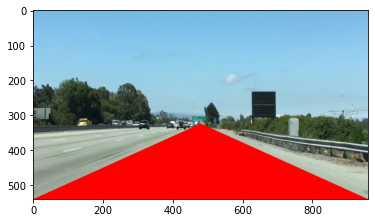

In [51]:
# Pull out the x and y sizes and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

# Define a triangle region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz 
left_bottom = [0, ysize]
right_bottom = [xsize, ysize]
apex = [xsize/2, ysize*.6]

logger.debug ('left_bottom = %s, right_bottom = %s, apex = %s', left_bottom, right_bottom, apex)

# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

logger.debug ('fit_left = %s, fit_right = %s, fit_bottom = %s', np.around(fit_left, decimals=1), np.around(fit_right, decimals=1), np.around(fit_bottom, decimals=1))


# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

logger.debug (region_thresholds)

# Color pixels red which are inside the region of interest
region_select[region_thresholds] = [255, 0, 0]
logger.debug (region_select)

# Display the image
plt.imshow(region_select)

# uncomment if plot does not display
# plt.show()

**Combining Color and Region Selections**

Now you've seen how to mask out a region of interest in an image. Next, let's combine the mask and color selection to pull only the lane lines out of the image.

Check out the code below. Here we’re doing both the color and region selection steps, requiring that a pixel meet both the mask and color selection requirements to be retained.


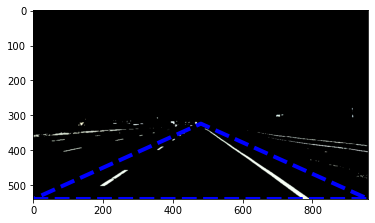

In [49]:
# Grab the x and y sizes and make two copies of the image
# With one copy we'll extract only the pixels that meet our selection,
# then we'll paint those pixels red in the original image to see our selection 
# overlaid on the original.
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

# Define our color criteria
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define a triangle region of interest (Note: if you run this code, 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
left_bottom = [0, ysize]
right_bottom = [xsize, ysize]
apex = [xsize/2, ysize*.6]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
# Mask color selection
color_select[color_thresholds] = [0,0,0]
# Find where image is both colored right and in the region
line_image[~color_thresholds & region_thresholds] = [255,0,0]

# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)
plt.imshow(color_select)
#plt.imshow(line_image)


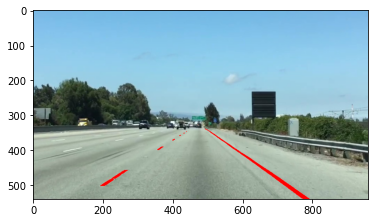

In [50]:
plt.imshow(line_image)
